In [1]:
%run ../widgets/config_check.py

In [2]:
# <api>
import numpy as np
from scipy.stats import norm, multivariate_normal
from matplotlib import pyplot as plt
%matplotlib inline

# Load classes and functions from the previous parts
from jupyter_cms.loader import load_notebook
smpl_intro = load_notebook('./Sampling_Intro_WS_Suggestions.ipynb')
smpl_rej = load_notebook('./Sampling_Rejection_WS_Suggestions.ipynb')
smpl_index = load_notebook('./Sampling_Index.ipynb')

In [3]:
smpl_index.help()

# Importance sampling

Importance sampling tries to fix the inefficiency of rejection sampling, by assigning weights to each sample instead of rejecting. It is based on the observation that
$$ \mathbb{E}_p[f] = \int f(x) p(x) dx = \int f(x) \frac{p(x)}{q(x)} q(x) dx = \mathbb{E}_q[f \frac{p}{q}] $$
for any function $f(x)$.

Thus, instead of using samples $x_1,\ldots,x_N$ from $p(x)$ to approximate the expectation $\mathbb{E}_p[f]$ of $f$ under $p$ as
$$ \mathbb{E}_p[f] \approx \frac{1}{N} \sum_{i=1}^n f(x_i) $$
we can just as well use samples from some other distribution $q(x)$ and evaluate the expectation of $f \frac{p}{q}$ under $q$.

This scheme can easily be extended when the normalization constant of $p(x)$ is not available, i.e. $p(x) = \frac{1}{Z} \hat{p}(x)$. Then,
$$ \mathbb{E}_p[f] = \int \frac{1}{Z} f(x) \hat{p}(x) dx = \frac{1}{Z} \mathbb{E}_q[f \frac{\hat{p}}{q}] $$
and since $\int p(x) dx = 1 = \frac{1}{Z} \int \frac{\hat{p}(x)}{q(x)} q(x) dx$, $Z$ can be found via importance sampling as well:
$$ Z = \int \frac{\hat{p}(x)}{q(x)} q(x) dx = \mathbb{E}_q[\frac{\hat{p}}{q}]$$

Thus, assuming that we have samples $x_1,\ldots,x_n$ from $q$, the expectation $\mathbb{E}_p[f]$ can be approximated as
$$ \mathbb{E}_p[f] \approx \frac{\sum_{i=1}^N f(x_i) w_i}{\sum_{i=1}^N w_i} $$
with $w_i = \frac{\hat{p}(x_i)}{q(x_i)}$ being the **_weight_** of sample $x_i$

In [4]:
# <api>
class ImportanceSampling (smpl_intro.Sampling):
    def __init__(self, log_p, q):
        """
        q is assumed to support sampling q.rvs and density evaluation q.pdf
        """
        self.log_p = log_p
        self.q = q
        
    def sample (self):
        """
        Note: Importance sampling returns a sample and its associated weight
        """
        x = self.q.rvs()
        w = np.exp(self.log_p(x) - self.q.logpdf(x))
        return [x,w]

In [8]:
# <api>
def weighted_gauss_hist (ax, weighted_data, bins):
    x = np.arange(-4,4,0.01)
    ax.hist(np.array(weighted_data)[:,0], bins, normed=True, 
            weights=np.array(weighted_data)[:,1])
    ax.plot(x, smpl_intro.phi(x), 'r-', alpha=0.7)
    ax.xlabel('x', fontsize=15)
    ax.ylabel('Probability', fontsize=15)
    ax.legend(['underlying dist.', 'samples'], fontsize=10, loc=1)
    ax.title("Histogram of sampled distribution", fontsize=15)

In [9]:
sampling = ImportanceSampling(log_p=lambda x: np.log(smpl_rej.p(x)), q=norm(loc=1,scale=2))

smpl_intro.show_sampling(sampling, plotter=weighted_gauss_hist, 
                    f_exp=lambda x: np.array(x[0])[:,1], true_exp=np.sqrt(2*np.pi))

Output()

We can also approximate the normalization constant of $p(x) = e^{-\frac{1}{2} x^2}$ by the mean of the sample weights:

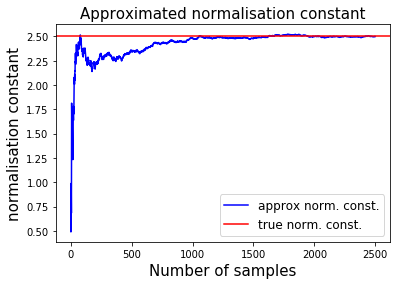

In [12]:
smpl_intro.show_expectation(sampling, lambda x: x[1]) # f extracts weight
plt.axhline(np.sqrt(2*np.pi), color='r'); # true normalization constant
plt.legend(['approx norm. const.', 'true norm. const.'], fontsize=12)
plt.xlabel('Number of samples', fontsize=15)
plt.ylabel('normalisation constant', fontsize=15)
plt.title('Approximated normalisation constant', fontsize=15);

Importance sampling can fail miserably if $q$ has thinner tails as<font color='red'>than</font> $p$. In this case, the weights $\frac{p(x)}{q(x)}$ can become arbitrarily large and dominate the weighted samples!

This effect is demonstrated below:

In [13]:
sampling = ImportanceSampling(log_p=lambda x: np.log(smpl_rej.p(x)), q=norm(loc=0,scale=0.25))

smpl_intro.show_sampling(sampling, plotter=weighted_gauss_hist, f_exp=lambda x: np.array(x[0])[:,1])

Output()

Is there a diagnostic to detect this type of problem?

In general, detecting the failure of a sampling methods can be quite difficult. Nevertheless the importance weights can give us some information about the effectiveness of importance sampling. We noted above, that the variance of the standard Monte-Carlo estimate using $N$ samples is given by
$$ \mathbb{V}ar_p[\frac{1}{N} \sum_{i=1}^N f(x_i)] = \frac{1}{N} \mathbb{V}ar_p[f] $$
Similarly, we could compute the variance of the weighted average used in importance sampling
$$ \mathbb{V}ar_p[\sum_{i=1}^N \frac{w_i}{\sum_{i=1}^N w_i} f(x_i)] = \frac{\sum_{i=1}^N w_i^2}{(\sum_{i=1}^N w_i)^2} \mathbb{V}ar_p[f] $$
Thus, by comparing coefficients we can define
$$ N_{eff} = \frac{(\sum_{i=1}^N w_i)^2}{\sum_{i=1}^N w_i^2} $$
as an approximate effective sampling size.

Note: This derivation is by no means exact, as the weights $w_i$ are actually not fixed, but dependent on the samples $x_i$. Thus, they are in particular not necessarily independent of $f(x_i)$ ...

In [14]:
# <api>
def ess (x):
    """
    Effective sample size of weighted samples x
    """
    w = np.array(x)[:,1] # extract weight
    return np.sum(w)**2/np.sum(w**2)

In [15]:
# <api>
def plt_ess (ax, weighted_data, bins):
    weighted_gauss_hist(ax, weighted_data, bins)    
    ax.text(1, 0.35, "N_eff = "+str(ess(weighted_data)))

In [16]:
smpl_intro.show_sampling(sampling, plotter=plt_ess, f_exp=lambda x: np.array(x[0])[:,1])

Output()

Some theoretical remarks on importance sampling:

* What is the optimal choice for $q$?

  Remember that the variance of a Monte-Carlo estimate for $\mu = \mathbb{E}_p[f]$ is given by $\frac{1}{N} \mathbb{V}ar_p[f]$. In importance sampling, the integrand is changed to $f \frac{p}{q}$ and the expectation is then evaluated with respect to the sampling density $q$. It is easy to see that the optimal choice would be $q(x) = \frac{p(x) f(x)}{\mu}$ with variance
  $$ \mathbb{V}ar_q[ f \frac{p}{q} ] = \mathbb{V}ar_q[ \mu ] = 0 $$
  Note: While optimal<font color='red'>,</font> this choice is infeasible since the normalization constant of this $q$ is equal to $\mu$, i.e. the mean of $f$ which is to be computed in the first place.

* In general, importance sampling can be considered a variance reduction technique. We compute $$ \mathbb{V}ar_p[f] - \mathbb{V}ar_q[f \frac{p}{q}] = \int f^2(x) (1 - \frac{p(x)}{q(x)}) p(x) dx $$
  Thus, importance sampling reduces the variances when $\frac{p(x)}{q(x)} < 1$ if $f(x) p(x)$ large, while allowing for $\frac{p(x)}{q(x)} > 1$ if $f(x) p(x)$ is small.

**Example**: Pricing an (out-of-the-money) Asian call option with importance sampling

Consider a Black-Scholes world, i.e. the stock price $S_t$ follows a geometric Brownian motion, i.e. $$ S_t = S_0 e^{(r - \frac{\sigma^2}{2}) t + \sigma W_t}$$ where $W_t$ denotes a Brownian motion.

Now, assume that an Asian call with strike $K$ <font color='red'>what is a strike?</font> and expiring at time $T$ pays
$$ a(S) = \max ( 0, \frac{1}{M} \sum_{i=1}^M S_{i \frac{T}{M}} - K ), $$
i.e. the stock price is averaged over days $i \frac{T}{M}$ for $i=1,\ldots,M$ and then compared with the strike $K$. Using the above formula for the stock price, we can compute $S_{i \frac{T}{M}} = S_0 e^{(r - \frac{\sigma^2}{2}) i \frac{T}{M} + \sigma \sqrt{\frac{T}{M}} (X_1 + \ldots + X_i)}$ where $X_i \sim \mathcal{N}(0,1)$ since the Brownian motion is the cumulative sum of standard normal increments.

The risk-neutral option <font color='red'>why is this risk neutral? Maybe some more steps would be helpful.</font> price is then computed as
$$ \mathbb{E}_S[ e^{-rT} a(S) ] $$

Below, we compute the price for an option that is vastly out of the money, i.e. $K \gg S_0$

<font color='red'>What exactly is being plotted here, just the stock price? I think a little more explanation of the example could be helpful for non economics students.</font>

In [17]:
# <api>
def stock_price (S_0, r, sigma, T, X):
    """
    Stock prices S_{i\frac{T}{M}} given a sequence X[1], ..., X[M] of normal increments
    """
    M = X.size
    i = np.arange(M) + 1 # i = 1,...,M
    return S_0*np.exp( (r-sigma**2/2.0)*i*T/M + sigma*np.sqrt(T/M)*np.cumsum(X) )

def a(S, K):
    return np.max([0, np.mean(S) - K])

class NormalIncrements (smpl_intro.Sampling):
    def __init__ (self, M):
        self.M = M
    def sample(self):
        return np.random.normal(size=(self.M,))
    
def out_of_money (X):
    sigma = 0.25/np.sqrt(365) # 25% yearly volatility
    S = stock_price(100, 0, sigma, 6*30, X)
    return a(S, 130)

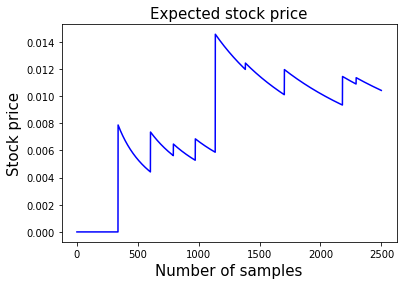

In [19]:
M = 100
smpl_intro.show_expectation(NormalIncrements(M), out_of_money)
plt.xlabel('Number of samples', fontsize=15)
plt.ylabel('Stock price', fontsize=15)
plt.title('Expected stock price', fontsize=15);

Next, the same with importance sampling shifting up the mean of the sampling distribution:
<font color='red'>what is the conclusion of this?</font>

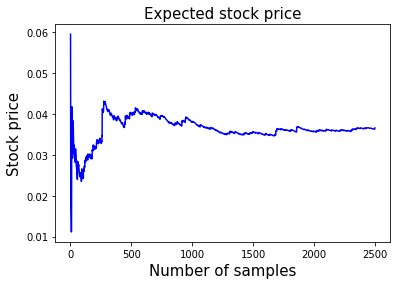

In [20]:
smpl_intro.show_expectation(ImportanceSampling(log_p = multivariate_normal(mean=np.zeros(10)).logpdf,
                                          q = multivariate_normal(mean=1.0*np.ones(10))), 
                       lambda X: X[1]*out_of_money(X[0]))
plt.xlabel('Number of samples', fontsize=15)
plt.ylabel('Stock price', fontsize=15)
plt.title('Expected stock price', fontsize=15);